# 1. Introduction
Motivation

Nous avons pour projet d’utliser des concepts d'apprentissage fédérés pour construire un 
pipeline d'apprentissage automatique basé sur des appareils mobiles et des appareils 
informatiques à carte unique tels que Raspberry .

Youtube est la plus grande plate-forme vidéo au monde avec des millions d'utilisateurs 
simultanés au quotidien et une grande influence sur le comportement, les croyances et les 
opinions des clients. De ce fait, l'optimisation des performances vidéo a acquis une valeur 
économique tangible et de nombreusesentreprises l'utilisent pour gagner en traction et 
susciter l'intérêt pour leurs produits et services.

Dans cette étude, nous visons à créer un modèle pour analyser les effets des balises vidéo 
dans les performances d'une vidéo. Nous explorerons à la fois les caractéristiques 
quantitatives et qualitatives des balises vidéo, en les comparant aux performances globales 
de la vidéo à travers une série de mesures telles que le nombre de vues, le rapport 
j'aime / n'aime pas et le nombre de jours de tendance.


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json

# 2. Datasets
## 2.1 À propos des données

Datasets utilisé: Trending YouTube Video Statistics

L'ensemble de données se compose d'enregistrements quotidiens des 200 vidéos YouTube les 
plus populaires, classés par pays. 
Aux fins de cette analyse, nous nous concentrerons sur les vidéos provenant de France (FR), 
Grande-Bretagne (GB), et l’Allemagne (DE)  pour la période comprise entre le 14 novembre 2017
et le 14 juin 2018, soit un total de 205 jours.

Nous avons dans un premier etudié les caractéristiques de chaque pays indépendamment, puis 
dans un second temps comparer ceux-ci entre eux.

La description des colonnes pertinentes de l'ensemble de données est présentée dans le 
tableau ci-dessous.




| Columns Header         | Quantity | Type   | Description |
| --------------         | -------- | ------ | ----------- |
| video_id               | 40949    | object | Unique Value for each video |
| trending_date          | 40949    | object | Date in which video is trending. Video can trend for over a day. | 
| title                  | 40949    | object | Video's title |
| channel_title          | 40949    | object | Name of uploading channel |
| category_id            | 40949    | int64  | Video category |
| publish_time           | 40949    | object | Time of upload |
| tags                   | 40949    | object | Tags associated with the video |
| views                  | 40949    | int64  | Number of views |
| likes                  | 40949    | int64  | Number of likes |
| dislikes               | 40949    | int64  | Number of dislikes |
| comment_count          | 40949    | int64  | Number of comments |
| comments_disabled      | 40949    | bool   | Comment section enabled or not |
| ratings_disabled       | 40949    | bool   | Like/Dislike ratio shown |
| video_error_or_removed | 40949    | bool   | Was the video deleted or not |
| description            | 40379    | object | Video description |

# 3. Méthodologie

## 3.1 Comprendre les "performances vidéo"

Il existe de nombreuses façons différentes de mesurer les performances d'une vidéo.
Dans notre étude, nous examinerons les performances vidéo sur la base de 2 aspects clés:
- **1. L'aspect de Popularité** 
  Nous etudirins ici les indicateurs relevant :
  - (Nombre de) J'aime
  - (Nombre de) commentaire
    
- **2. L'Engagement**
  - (Nombre de) vues
  - durée de la tendance = (date actuelle - date_tendance)


### 3.1.1 L'aspect de Popularité 

Tout d'habors, nous avons pris connaissance du dataset en explorant les idicateurs 
relevants le nombre de j'aime et  de commentaire en plotant nos premiers histograms.


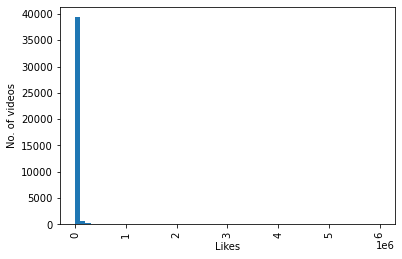

In [39]:
videos = pd.read_csv("FRvideos.csv")

plt.rc('figure.subplot', wspace=0.9)
fig, ax = plt.subplots()
_ = sns.distplot(videos["likes"], kde=False, hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 6e6, 61), ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos")
_ = plt.xticks(rotation=90)

Nous notons que la grande majorité des vidéos tendances ont entre 0 et 1 000 000 likes. 
Laissez-nous tracer l'histogramme uniquement pour les vidéos avec 100 000 likes ou moin
s pour voir de plus près la distribution des données

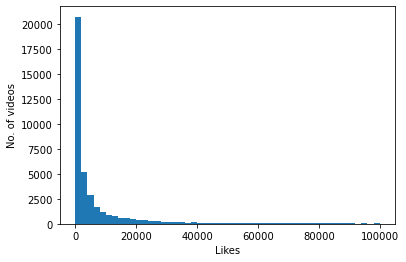

In [40]:
fig, ax = plt.subplots()
_ = sns.distplot(videos[videos["likes"] <= 1e5]["likes"], kde=False, hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos")

Maintenant, nous pouvons voir que la majorité des vidéos tendances ont 40000 likes ou moins
avec un pic pour les vidéos avec 2000 likes ou moins.

Voyons le pourcentage exact de vidéos avec moins de 40000 likes

In [41]:
videos[videos['likes'] < 4e4]['likes'].count() / videos['likes'].count() * 100

92.06119241724781

De même, nous pouvons voir que le pourcentage de vidéos avec moins de 100 000 likes 
est d'environ 92%

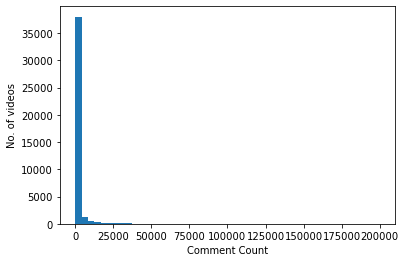

In [42]:
fig, ax = plt.subplots()
_ = sns.distplot(videos[videos["comment_count"] < 200000]["comment_count"], kde=False, rug=False, hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 2e5, 49), ax=ax)
_ = ax.set(xlabel="Comment Count", ylabel="No. of videos")

In [43]:
videos[videos['likes'] < 4000]['likes'].count() / videos['likes'].count() * 100

63.75110499950889

De même, nous pouvons voir que le pourcentage de commentaire avec moins de  4000 likes 
est d'environ 63%

### 3.1.2 L'Engagement
Dans cette partie, nous etudions: 
  - (Nombre de) vues
  - durée de la tendance = (date actuelle - date_tendance)

Avant l'algorithme réel, nous devons sélectionner nos données d'entrée.

Tout d'abord, les vidéos qui ne sont pas utiles pour notre cas sont supprimées de 
l'échantillon. Cela inclut les vidéos avec des erreurs, où les commentaires et / ou les 
évaluations sont désactivés et les vidéos en double.

Par la suite, nous avons ajouter deux colonnes : "publish_time" et "trending_date". Nous les 
avons reformaté pour pouvoir par la suite etudier plus facilement la correlation entre les
dates de sorties des videos, et leur appartions en tendance. 

In [44]:
# count days of trending
# trending_period = videos_clean.groupby(['video_id']).size().reset_index(name='trending_period')

videos_clean = videos.drop(columns=['thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'description', 'publish_time', 'trending_date'])

# formating date
videos_clean['publish_time'] = pd.to_datetime(videos['publish_time'], format='%Y-%m-%dT%H:%M:%S.000Z', utc=False)
videos_clean['trending_date'] = pd.to_datetime(videos['trending_date'], format='%y.%d.%m', utc=False)

# drop duplicate and keep newest videos
videos_clean = videos_clean.sort_values(by=['trending_date']).reset_index()

In [45]:
views_trending = videos_clean.filter(['video_id', 'views', 'trending_date'])
views_trending_grouped = views_trending.groupby(by='video_id')

views_increase = pd.DataFrame(views_trending_grouped['views'].count())

views_diff = []
for video_id in views_trending_grouped.groups:
    video_group = views_trending_grouped.get_group(video_id)
    views_diff.append(video_group['views'].max() - video_group['views'].min())
views_increase['views_diff'] = views_diff


Par la suite, nous avons selectionné uniquement les videos qui sont restées en tendance 
plus d'un jour.
Nous avons vu ainsi evaluer le nombre de vue gagné pour les videos.

c:\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


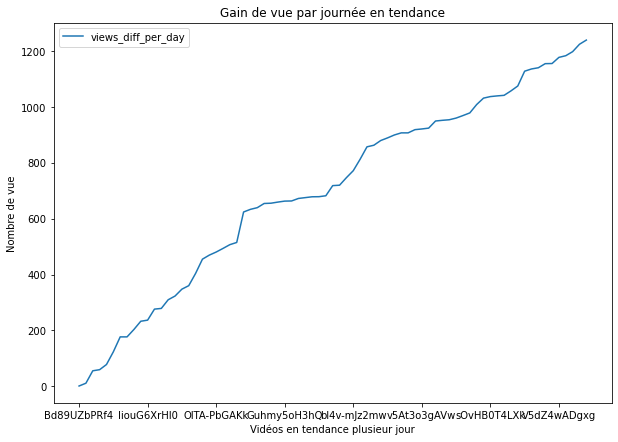

In [46]:

views_increase_multi_days = views_increase[views_increase["views"] != 1]

views_increase_multi_days['views_diff_per_day'] = views_increase_multi_days['views_diff'] / views_increase_multi_days['views']

nb_vid = len(views_increase_multi_days)
percentage = 1/100
keeped_video = int(nb_vid*percentage)

views_increase_multi_days.describe()
views_increase_multi_days.sort_values('views_diff_per_day')

view = views_increase_multi_days.sort_values('views_diff_per_day')[:keeped_video]
view.plot(y='views_diff_per_day', figsize=(10,7))
plt.title("Gain de vue par journée en tendance")
plt.xlabel("Vidéos en tendance plusieur jour")
plt.ylabel("Nombre de vue")
plt.show()

# >>> CONCLUSION 2.Engagement <<<

## 3.2 Impact de la date de parution

### 3.2.1 Objectif

Nous nous somme posé la question si le jour de parution de la vidéo pouvais optimiser nos chance de rentrer en tendance.

L'objectif de cette analyse est savoir qu'elle jour est le plus propice pour poster une vidéo.
On peut essayer de chercher des indice en mesurant pour chaque video la difference entre son jour de publication et celui de son entré en tendance.
Puis des les afficher par jour. On pourrait alors par la suite essayer de regarder par category pour voir si certaine catégorie ce demarque de la tendance génerale.

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def clean_youtube_dataset(csv_file, keeped):
    videos = pd.read_csv(csv_file)

    videos_clean = videos.drop(columns=['thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'description', 'publish_time', 'trending_date'])

    # formating date
    videos_clean['publish_time'] = pd.to_datetime(videos['publish_time'], format='%Y-%m-%dT%H:%M:%S.000Z', utc=False)
    videos_clean['trending_date'] = pd.to_datetime(videos['trending_date'], format='%y.%d.%m', utc=False)

    # drop duplicate and keep newest videos
    return videos_clean.sort_values(by=['trending_date']).drop_duplicates(subset=['video_id'], keep=keeped).reset_index()

FRvideos = clean_youtube_dataset('FRvideos.csv', 'first')
GBvideos = clean_youtube_dataset('GBvideos.csv', 'first')
DEvideos = clean_youtube_dataset('DEvideos.csv', 'first')

In [48]:
def trending_time_mean_per_week( videos, title):
    videos = videos.filter(['trending_date', 'publish_time'])
    
    # remove video before november 2017
    videos = videos[videos['publish_time'] > '2017-11-1']
    
    # add column with day day of the week
    videos['day_of_the_week'] = videos['trending_date'].dt.dayofweek
    
    videos['time_to_trended'] = videos['trending_date'] - videos['publish_time']
    videos['time_to_trended_seconds'] = videos['time_to_trended'].dt.seconds + videos['time_to_trended'].dt.days * 86400
    videos['time_to_trended_days'] = videos['time_to_trended_seconds'] / (60 * 60 * 24)

    videos_per_day = videos.groupby('day_of_the_week').mean()
    videos_per_day = videos_per_day.reset_index()
    
    # convert number to day name
    days_of_week = {0: 'Monday', 1: 'Thuesday', 2: 'Wenesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday',}
    videos_per_day['day_of_the_week'] = videos_per_day['day_of_the_week'].map(days_of_week)

    videos_per_day.plot(kind='bar', x='day_of_the_week', y='time_to_trended_days', color='red', figsize=(10,5))
    plt.title(title)
    plt.xticks(rotation=0)
    plt.xlabel("Jour de la semaine")
    plt.ylabel("Temps de publication moyen en jour")

    plt.show()

Le premier choix fait a du etre de retirer les videos les plus vieilles j'ai donc choisi de prendre uniquement les vidéos publiées après novembre 2017, soit 2 semaine avant la premier date de tendance dans notre dataset.

```python
# remove video before november 2017
videos = videos[videos['publish_time'] > '2017-11-1']
```

Cette opération a par exemple beaucoup corriger l'écart type dans le dataset d'Angleterre. Nous nous sommes rendu compte que beaucoup de video en tendance pendant cette période était ancienne .

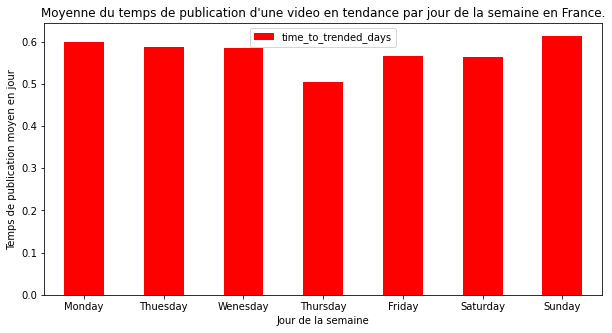

In [49]:
trending_time_mean_per_week(FRvideos, "Moyenne du temps de publication d'une video en tendance par jour de la semaine en France.")

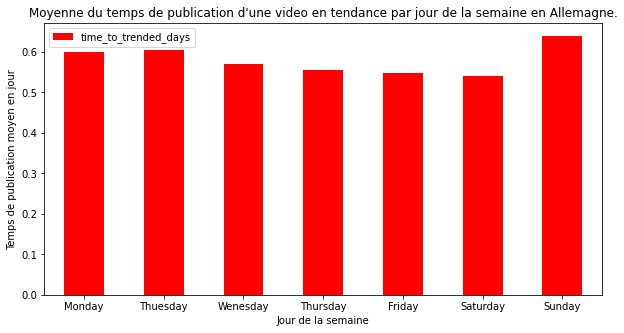

In [50]:
trending_time_mean_per_week(DEvideos, "Moyenne du temps de publication d'une video en tendance par jour de la semaine en Allemagne.")

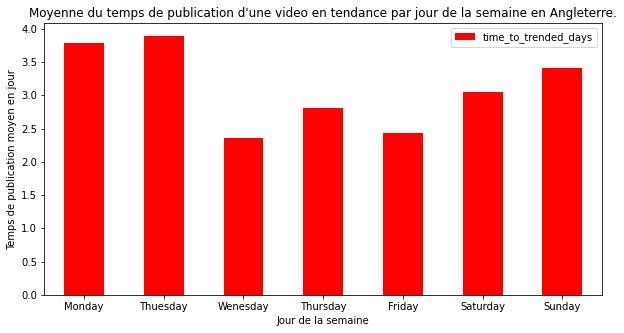

In [51]:
trending_time_mean_per_week(GBvideos, "Moyenne du temps de publication d'une video en tendance par jour de la semaine en Angleterre.")

### 3.2.2 Analyse

On remaque peu de difference entre le dataset d'Allemagne est de la France la tendance est d'environ 12h, c'est-à-dire que les video sont en moyenne posté 12h a l'avance. Les données en angleterre sont beaucoup plus intéréssante. Tout d'abort on remarque que la moyenne est beaucoup plus proche de 3 jours. On note aussi que le mercredi, le jeudi et le vendredi les moyennes sont nettement inférieur au autre jour, environ 1 jour et 12 heures. On peut donc conclure que les videos poster le lundi est le mardi sont plus propice à entrer en tendance.


## 3.3 Etude sur la signification des tags

### 3.3.1 Objectif de l'analyse

L'objectif de cette analyse est de comprendre comment évolue les tags des vidéos celon les dates de publication de celle ci, on pourra ainsi mettre en évidence l'influence de certaine période de l'année sur les tags ou encore d'événement marquant.

### 3.3.2 Nettoyage des données

Dans un premier temps on nettois les données du Dataframe sélectionné en retirant les colonnes non utile à la comprehension du dataframe, on met ensuite les dates du dataframe a format datetime de python pour faciliter le traitement des données. Ensuite on supprime les doublons du dataframe.

In [52]:
videos_cleanfr = clean_youtube_dataset('FRvideos.csv', 'last')
videos_cleande = clean_youtube_dataset('GBvideos.csv', 'last')
videos_cleangb = clean_youtube_dataset('DEvideos.csv', 'last')

*La fonction explode permet de convertir une colonne de liste en une colonne avec toute les elements de toute les listes*

In [53]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    #cv preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

### 3.3.3 Analyse des données

On peut tout d'abord visionner les tags les plus populaires de chaque dataframe sans les visionner par mois pour vérifier si les tags les plus populaires de l'année se retrouve ensuite dans les différent mois.

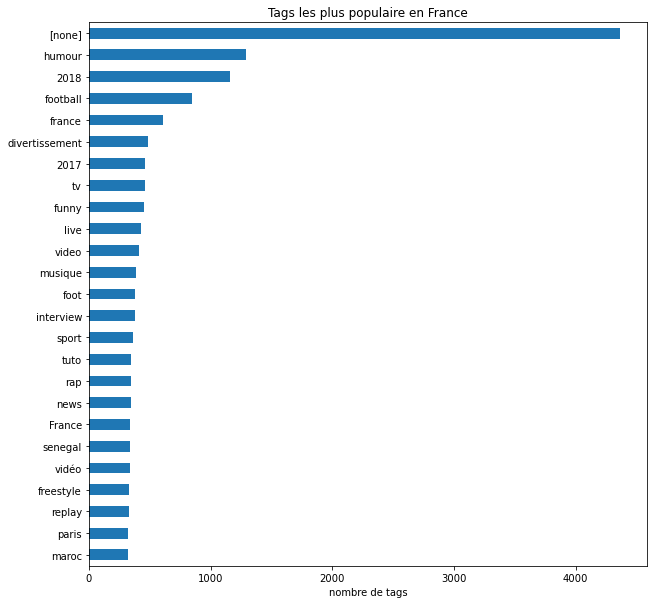

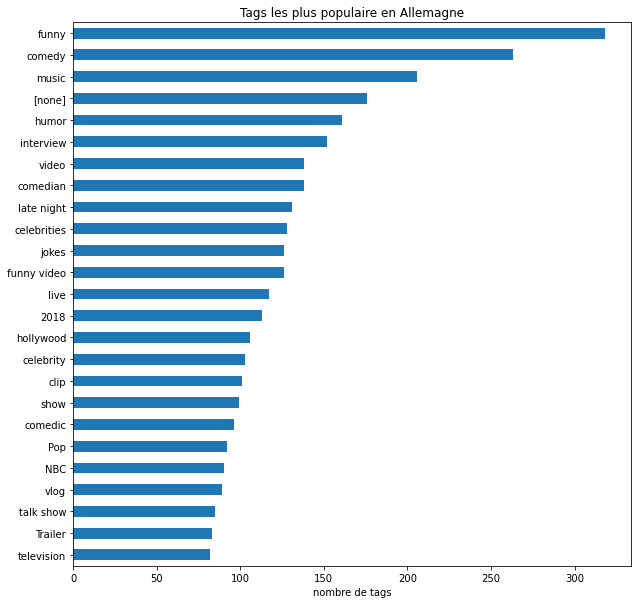

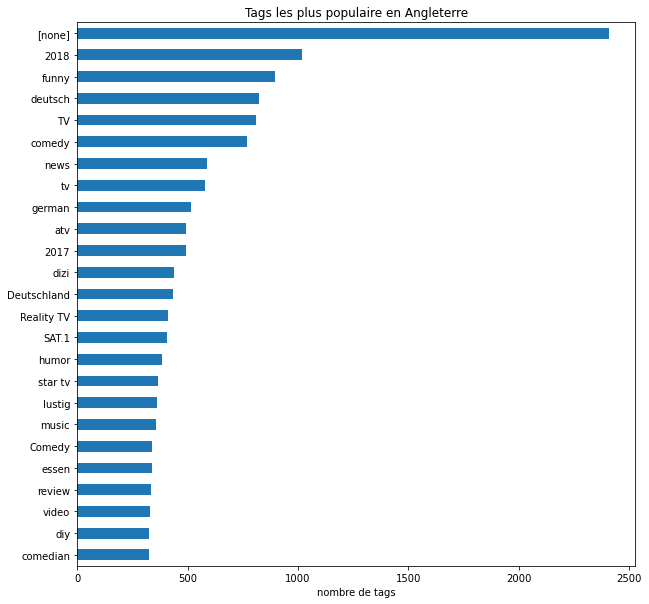

In [54]:
tagsfr = videos_cleanfr.filter(['tags'])
tagsde = videos_cleande.filter(['tags'])
tagsgb = videos_cleangb.filter(['tags'])

tagsfr['tags'] = tagsfr['tags'].str.replace('"','')
tagsfr['tags'] = tagsfr['tags'].str.split('|')
tagsfr = explode(tagsfr, ['tags'], fill_value='')
tags_most_usedfr = tagsfr['tags'].value_counts().head(25).sort_values()
tags_most_usedfr.plot(kind='barh',
                    figsize=(10,10))
plt.title('Tags les plus populaire en France')
plt.xlabel("nombre de tags")
plt.show()

tagsde['tags'] = tagsde['tags'].str.replace('"','')
tagsde['tags'] = tagsde['tags'].str.split('|')
tagsde = explode(tagsde, ['tags'], fill_value='')
tags_most_usedde = tagsde['tags'].value_counts().head(25).sort_values()
tags_most_usedde.plot(kind='barh',
                    figsize=(10,10))
plt.title('Tags les plus populaire en Allemagne')
plt.xlabel("nombre de tags")
plt.show()

tagsgb['tags'] = tagsgb['tags'].str.replace('"','')
tagsgb['tags'] = tagsgb['tags'].str.split('|')
tagsgb = explode(tagsgb, ['tags'], fill_value='')
tags_most_usedgb = tagsgb['tags'].value_counts().head(25).sort_values()
tags_most_usedgb.plot(kind='barh',
                    figsize=(10,10))
plt.title('Tags les plus populaire en Angleterre')
plt.xlabel("nombre de tags")
plt.show()



Dans la cellule précedente on peut remarquer que le "tag" le plus utilisé dans les vidéos Allemande et Francaise en tendance est le tag [none] en réalité cela signifie que la plupart du temps ces vidéos ne comporte pas de tag, mais est-ce le cas si on visionne l'utilisation des tags par mois?
C'est ce que l'on va visionner maintenant :

In [55]:
def display_tag_per_country(videos_clean):
    tags_days = videos_clean.filter(['tags', 'trending_date'])
    tags_days['trending_date'] = tags_days['trending_date'].dt.to_period('M')

    tags_days['tags'] = tags_days['tags'].str.lower()
    tags_days['tags'] = tags_days['tags'].str.replace('"','')
    tags_days['tags'] = tags_days['tags'].str.split('|')
    tags_days = explode(tags_days, ['tags'], fill_value='')

    tags_month_group = tags_days.groupby(by='trending_date')

    figure, axes = plt.subplots(4, 2)
    for index, month in enumerate(tags_month_group.groups.keys()):
        tags_month = tags_month_group.get_group(month)
        tags_frequency = tags_month['tags'].value_counts().head(20)

        #tags_frequency = tags_frequency.drop('[none]', axis=0).sort_values()
        tags_frequency = tags_frequency.sort_values()

        axes[int(index/2), index%2].set_title("{}".format(month))
        tags_frequency.plot(kind='barh', 
                            figsize=(20,20),
                            ax=axes[int(index/2), index%2])

    figure.suptitle('Tags les plus populaire par mois en France')
    plt.xlabel("nombre de tags")
    plt.show()

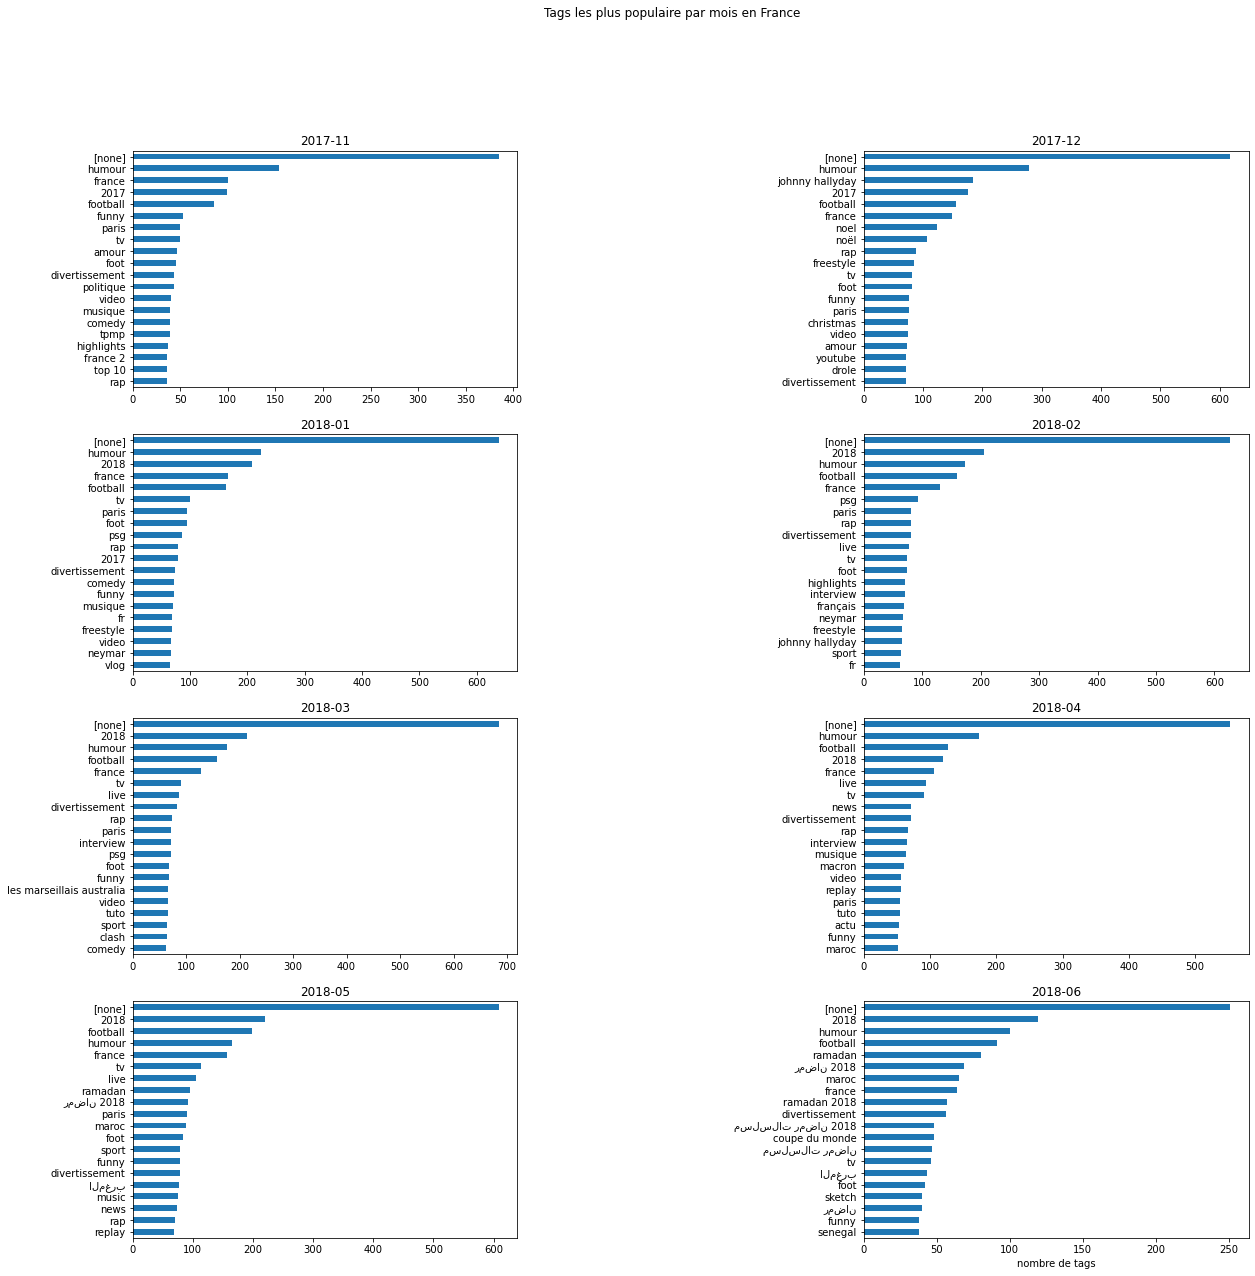

In [56]:
display_tag_per_country(videos_cleanfr)

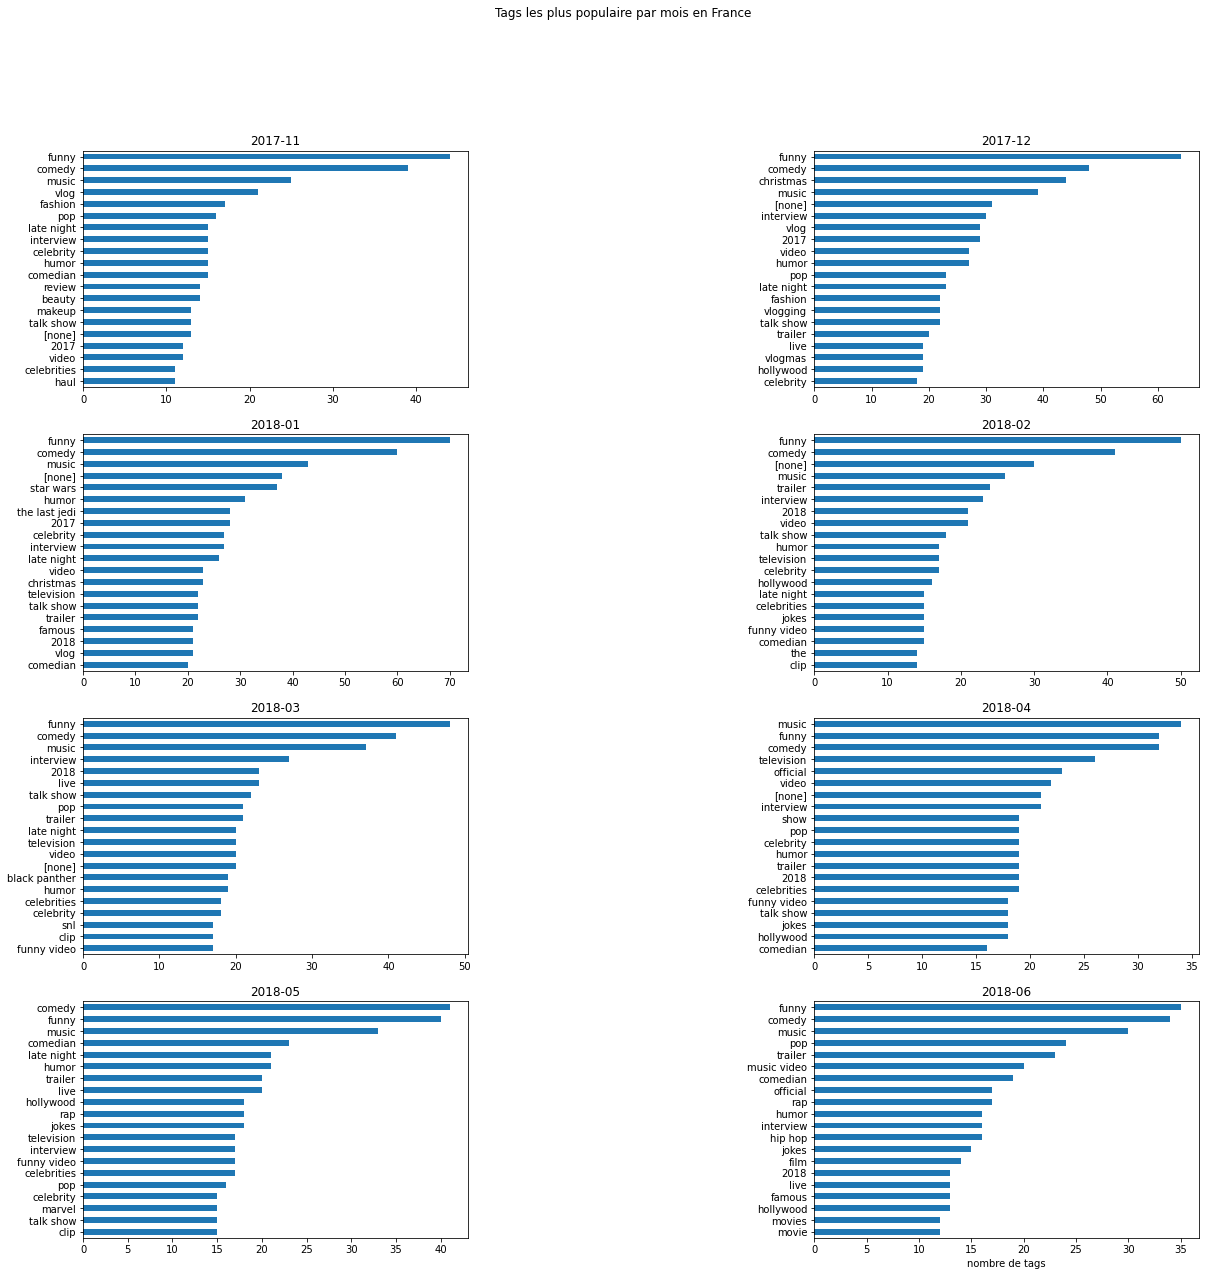

In [57]:
display_tag_per_country(videos_cleande)

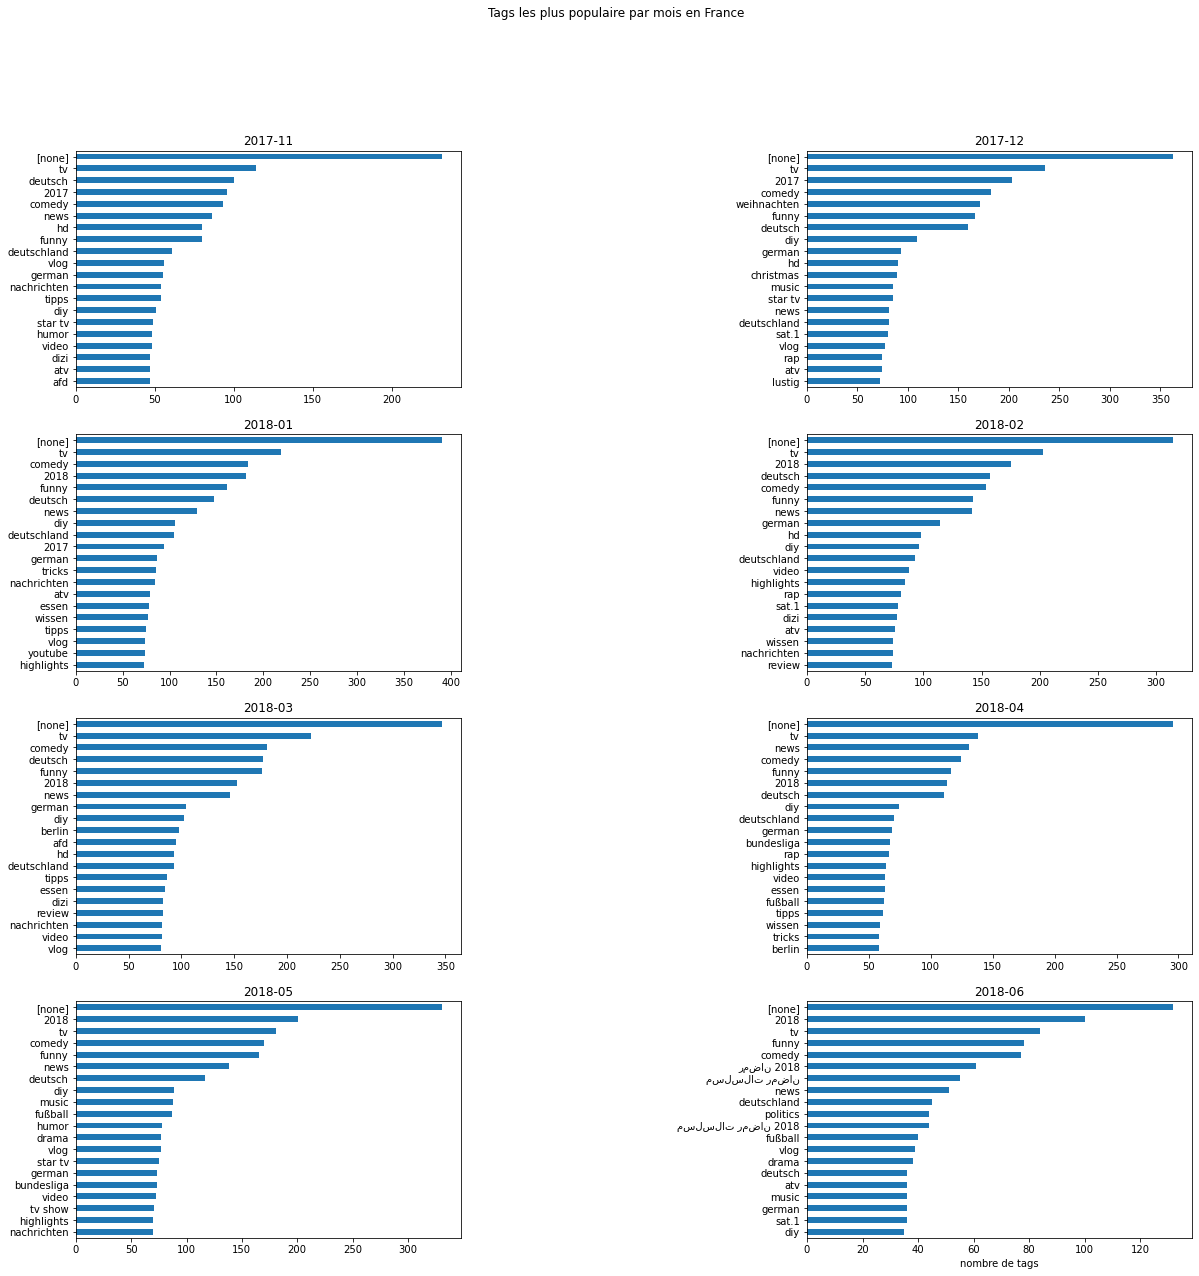

In [58]:
display_tag_per_country(videos_cleangb)

### 3.3.4 Conclusion sur les Tags

Le résultat concernant le tag [none] reste le même pour la France et l'Allemagne néanmoins on peut remarquer que en Grande Bretagne les tags les plus populaires sont souvent en liens avec l'humour ("funny", "comedy"), les autres tags sont cette fois bien différent celon le mois que l'on visionne, il semble donc bien y a voir un liens entre la periode de publication et les tags utlisés, on voit par exemple que lors de la période où Johnny Haliday est mort, en France, le tag "Johnny Halliday" est le 3eme plus utilisé.
Pourtant ce résultat est bien spécifique à la France on pourra ensuite comparer ces résultat avec les résultat des dataframes d'autres pays pour voir si certains tags sont internationals.

### 3.3.5 Analyse des catégories

Dans la cellule suivante le résultat obtenue est un classement des catégorie les plus vues, encore une fois en France. On pourra plus tard lié les tags au catégorie pour permettre de savoir quels sont les tags les plus populaires et efficace dans chaque catégorie.

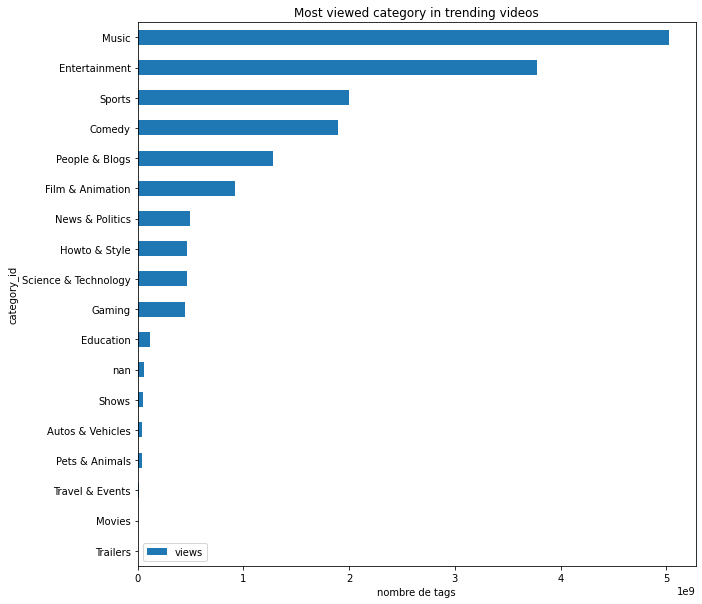

In [59]:



cat_per_likes = videos_clean.filter(['category_id', 'views'])
category_grouped = cat_per_likes.groupby(by='category_id').sum().sort_values(by='views', ascending=True)

category_grouped = category_grouped.reset_index()

category_grouped['category_id'] = category_grouped['category_id'].astype(str)

with open('FR_category_id.json', 'r') as category_file:
    category_data = (json.load(category_file))['items']
    
category_id = {}
for cat in category_data:
    category_id[cat['id']] =  cat['snippet']['title']

category_grouped['category_id'] = category_grouped['category_id'].map(category_id)

category_grouped.plot(kind='barh',
                      y='views',
                      x='category_id',
                      figsize=(10,10),
                      title='Most viewed category in trending videos',
                     )
plt.xlabel("nombre de tags")
plt.show()

Dans la cellule suivante, on essaye de visualiser les mots les plus utilisés dans les titres des videos en tendance, cela n'est qu'une ébauche.